In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
from utils import device, gaussian_grid, get_coords, to_tensor
from torch.optim import RMSprop
from torch.optim.lr_scheduler import ExponentialLR
from tqdm import tqdm

In [2]:
class PlaceFields(nn.Module):
    def __init__(self, coords, mean=np.zeros(2), cov=np.eye(2), scale=1):
        super().__init__()
        self.coords = coords
        
        self.mean = nn.Parameter(to_tensor(mean))
        self.cov_inv = nn.Parameter(to_tensor(cov))
        self.scale = nn.Parameter(to_tensor(scale))
    
    def forward(self, real):
        return torch.pow(self.predict() - real, 2).sum()
    
    # Calculate parametrized PDF over all coordinates
    def predict(self):
        diff = self.coords.view(-1, 2) - self.mean
        pred = self.scale * torch.e ** -((diff * (diff @ self.cov_inv)).sum(1) / 2)
        return pred.view(*self.coords.shape[:-1])

In [3]:
res = 400
bounds = (-1, 1)

x = torch.linspace(*bounds, res, device=device)
x = torch.meshgrid(x, x, indexing='ij')
coords = torch.stack(x).view(2, -1).T.view(res, res, 2)

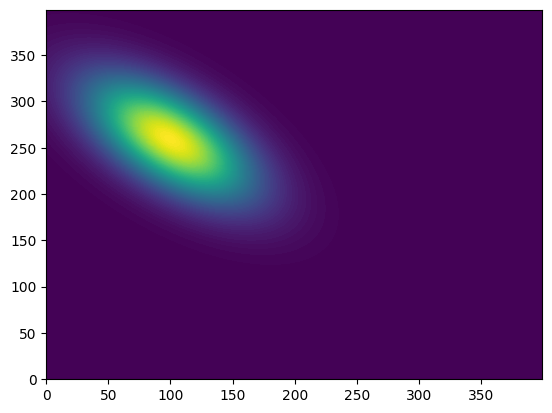

In [4]:
mean = [0.3, -0.5]
cov = [[0.05, -0.03],
       [-0.03, 0.05]]

mvn = multivariate_normal(mean=mean, cov=cov)
place = gaussian_grid(coords.cpu(), [mvn])

plt.contourf(place, levels=100)
plt.show()

In [5]:
pfs = PlaceFields(coords)
optim = RMSprop(pfs.parameters(), lr=1e-1)
# scheduler = ReduceLROnPlateau(optim)
scheduler = ExponentialLR(optim, gamma=0.9985)

real = to_tensor(place) * 0.1

losses = list()
for _ in tqdm(range(2000)):
    optim.zero_grad()
    loss = pfs(real)
    loss.backward()
    optim.step()
    scheduler.step()
    losses.append(loss.detach().cpu().item())

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 447.27it/s]


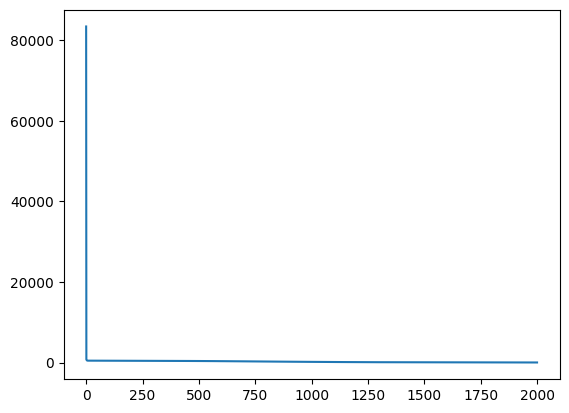

In [6]:
plt.plot(losses[0:])

In [7]:
pfs.mean

Parameter containing:
tensor([ 0.2989, -0.5045], device='cuda:0', requires_grad=True)

In [8]:
torch.inverse(pfs.cov_inv)

tensor([[ 0.0681, -0.0320],
        [-0.0320,  0.0712]], device='cuda:0', grad_fn=<LinalgInvExBackward0>)

In [9]:
pfs.scale

Parameter containing:
tensor(0.3097, device='cuda:0', requires_grad=True)

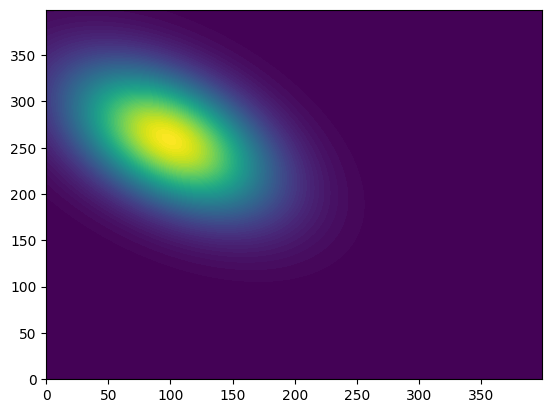

In [10]:
plt.contourf(pfs.predict().detach().cpu(), levels=100)
plt.show()